In [1]:
import Bio.PDB, warnings
pdb_list = Bio.PDB.PDBList()
pdb_parser = Bio.PDB.PDBParser()

import pandas as pd
from Bio import SeqIO
from Bio.PDB import *
from Bio import BiopythonWarning
import pickle
import numpy as np
from scipy import linalg
from sklearn.preprocessing import OneHotEncoder
import expectation_reflection as ER
from direct_info import direct_info
from direct_info import sort_di
from direct_info import sindex_di
from joblib import Parallel, delayed
import ecc_tools as tools
from glob import glob
import data_processing as dp
import inspect
from scipy.spatial import distance_matrix
#from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import sys, os
#========================================================================================
# Loop Throught covid proteins
#========================================================================================
parser = PDBParser()
pdb_files = glob('*.pdb')
pdb_structures = [pdb_name[:-4] for pdb_name in pdb_files]
#print(pdb_structures)

# Dictionary of pdb residue ranges (from https://zhanglab.ccmb.med.umich.edu/COVID-19/ ):
unknown_pdb_ranges = ['QHD43420', 'QHD43415_2', 'QHD43417','QHD43415_13', 'QHD43415_12', 'QHD43418', 'QHD43415_5', 'QHD43421','QHD43422', 'QHD43419','QHD43415_6', 'QHD43415_1']

pdb_ranges = { 'QHD43423':[('6M3M',50,174)], 'QHD43415_8':[('6M71',84,132)], 'QHD43415_7':[('6M71',1,83)], 'QHD43415_3':[('6W6Y',207,379),('6W9C',748,1060)],  'QHD43415_4':[('6LU7',1,306)],  'QHD43415_14':[('6VWW',1,346)], 'QHD43415_9':[('6W4B',1,113)],   'QHD43415_15':[('6W75',1,298)], 'QHD43415_11':[('6M71',1,932)], 'QHD43415_10':[('6W75',1, 139)], 'QHD43416':[('6VYB' ,1,1273),('6VXX',1,1273)]}#('6LXT',912,988,1164,1202)]} #DYNAMIC RANGE IS NOT INCORPRATED>>> NOT PLOTTING 3RD TYPE

#pdb_ranges = { 'QHD43415_7':[('6M71',1,83)]}

#cov_list = ["QHD43415_7"] # testing
cov_list = np.load('covid_protein_list.npy')


from scipy.sparse import csr_matrix
from joblib import Parallel, delayed
import timeit

import matplotlib.pyplot as plt
%matplotlib inline

import sys
import numpy as np
from scipy import linalg
from sklearn.preprocessing import OneHotEncoder
import expectation_reflection as ER
from direct_info import direct_info
from joblib import Parallel, delayed

sys.path.append('../biowulf')
# import pydca for plmDCA
from pydca.plmdca import plmdca
from pydca.meanfield_dca import meanfield_dca
from pydca.sequence_backmapper import sequence_backmapper
from pydca.msa_trimmer import msa_trimmer
from pydca.contact_visualizer import contact_visualizer
from pydca.dca_utilities import dca_utilities

#=========================================================================================
def predict_w(s,i0,i1i2,niter_max,l2):
    #print('i0:',i0)
    i1,i2 = i1i2[i0,0],i1i2[i0,1]

    x = np.hstack([s[:,:i1],s[:,i2:]])
    y = s[:,i1:i2]

    h01,w1 = ER.fit(x,y,niter_max,l2)

    return h01,w1

#-------------------------------


tools.hide_toggle()

In [2]:
pfam_id = "QHD43415_9"
pfam_id = "QHD43415_15"


# Read in Protein structure
sys.path.append(os.path.dirname('/home/eclay/DCA_ER/biowulf'))
root_dir = '/home/eclay/DCA_ER/covid_proteins'

dir_list = glob(root_dir+"/*/")

string ="/home/eclay/DCA_ER/covid_proteins/QHD"
covid_protein_list = []

parser = PDBParser()

pdb_ranges = { 'QHD43423':[('6M3M',50,174)], 'QHD43415_8':[('6M71',84,132)], 'QHD43415_7':[('6M71',1,83)], \
              'QHD43415_3':[('6W6Y',207,379),('6W9C',748,1060)],  'QHD43415_4':[('6LU7',1,306)],  \
              'QHD43415_14':[('6VWW',1,346)], 'QHD43415_9':[('6W4B',1,113)],   'QHD43415_15':[('6W75',1,298)],\
              'QHD43415_11':[('6M71',1,932)], 'QHD43415_10':[('6W75',1, 139)], \
              'QHD43416':[('6VYB' ,1,1273),('6VXX',1,1273)]}#('6LXT',912,988,1164,1202)]} 
                #DYNAMIC RANGE IS NOT INCORPRATED>>> NOT PLOTTING 3RD TYPE


generating_msa = False
if generating_msa:
        for pfam_dir in dir_list:
                pfam_id = pfam_dir[44:-1]
                print('Generating MSA array for ',pfam_id)
                # only work on QHD directoies
                if pfam_id[:2] != 'QH':
                        continue

                # Create msa.npy
                try:

                        with open(pfam_dir+"/MSA/protein.aln", 'r') as infile:
                                MSA = infile.readlines()
                        msa = []
                        for i,line in enumerate(MSA):
                                #print(line)
                                msa.append(list(line)[:-1])
                                print(list(line)[:-1])
                                #print(msa[i,:])
                        np.save(pfam_id+'/msa.npy',np.asarray(msa))

                        print('msa: ',msa[0])
                        covid_protein_list.append(pfam_id)
                except(FileNotFoundError):
                        print('No MSA file')
                        continue

        print(covid_protein_list) # list of covid proteins with MSA
        np.save('covid_protein_list.npy',covid_protein_list)


cov_list = np.load('covid_protein_list.npy')

if not generating_msa:
    msa =   np.load(pfam_id+'/msa.npy')
no_existing_pdb = False
print('\n\n\n',pfam_id,'\n')

# data processing

ipdb =0
s0,cols_removed,s_index,s_ipdb = dp.data_processing_covid(root_dir,pfam_id,ipdb,gap_seqs=0.2,gap_cols=0.2,prob_low=0.004,conserved_cols=0.9)
print('done with data processing')

pf_dict = {}
pf_dict['s0'] = s0
pf_dict['s_index'] = s_index
pf_dict['s_ipdb'] = s_ipdb
pf_dict['cols_removed'] = cols_removed

with open('%s/DP.pickle'%(pfam_id), 'wb') as f:
        pickle.dump(pf_dict, f)
f.close()

print("Writing FASTA")
path = "/home/eclay/DCA_ER/covid_proteins/%s/"%(pfam_id)
path = "%s/"%(pfam_id)

s_ipdb =  0
dp.write_FASTA(s0,pfam_id,s_ipdb,number_form=True,processed = True,path=path)


try:
        pdb =   [ [pfam_id , '0', pfam_id       , pdb_ranges[pfam_id][a][1]  ,  pdb_ranges[pfam_id][a][2]  ,\
                   pdb_ranges[pfam_id][a][0]  ,'A', pdb_ranges[pfam_id][a][1]  ,\
                   pdb_ranges[pfam_id][a][2]] for a in range(0,len(pdb_ranges[pfam_id])) ]
except(KeyError):
        pdb_ranges[pfam_id] = [('SIM',0,0)]
        no_existing_pdb = True

try:
        subject = msa[0]
        L = len(subject)

        if 0 :
                # Create pdb_refs.npy   
                structure = parser.get_structure(id =pfam_id, file =pfam_id+'.pdb')
                ppb=PPBuilder()
                cppb = CaPPBuilder()
                for pp in ppb.build_peptides(structure):
                        print(pp.get_sequence())
                        
                for model in structure:
                        for chain in model:
                                #print( inspect.getmembers(chain))
                                print(chain.get_full_id())
                                print(chain.get_residues())
                                for residue in  chain.get_residues():
                                        #print( inspect.getmembers(residue))
                                        print(residue)
                                        print(residue.get_full_id())
                                        for i,a in enumerate(residue):
                                                #print(a.get_name())
                                                #print(a.get_id())
                                                print(a.get_coord())      # atomic coordinates
                                                #print(a.get_occupancy())  # occupancy
                                                #print(a.get_altloc())     # alternative location specifier
                                        print( inspect.getmembers(a))
        print('subject sequence: ', subject)
except(FileNotFoundError):
        print('No PDB structure')
print('\n\n\n\n')


tools.hide_toggle()




 QHD43415_15 

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 

In [3]:
simulating = True
np.random.seed(1)
if simulating:
    print("RUNNING SIM FOR %s"%(pfam_id))

    #------- DCA Run -------#
    msa_outfile = '%s/MSA_%s.fa'%(pfam_id,pfam_id)

    # MF instance 
    mfdca_inst = meanfield_dca.MeanFieldDCA(
        msa_outfile,
        'protein',
        pseudocount = 0.5,
        seqid = 0.8,
    )

    # Compute DCA scores 
    sorted_DI_mf = mfdca_inst.compute_sorted_DI()
    sindex_DI_mf = sindex_di(sorted_DI_mf,s_index)

    with open('%s/DI_DCA.pickle'%(pfam_id), 'wb') as f:
        pickle.dump(sorted_DI_mf, f)
    f.close()
    #-----------------------#
    #------- PLM Run -------#

    # PLM instance
    plmdca_inst = plmdca.PlmDCA(
        msa_outfile,
        'protein',
        seqid = 0.8,
        lambda_h = 1.0,
        lambda_J = 20.0,
        num_threads = 16,
        max_iterations = 500,
    )

    # Compute DCA scores 
    sorted_DI_plm = plmdca_inst.compute_sorted_DI()
    sindex_DI_plm = sindex_di(sorted_DI_plm,s_index)

    with open('%s/DI_PLM.pickle'%(pfam_id), 'wb') as f:
        pickle.dump(sorted_DI_plm, f)
    f.close()

    n_var = s0.shape[1]
    mx = np.array([len(np.unique(s0[:,i])) for i in range(n_var)])
    mx_cumsum = np.insert(mx.cumsum(),0,0)
    i1i2 = np.stack([mx_cumsum[:-1],mx_cumsum[1:]]).T

    #onehot_encoder = OneHotEncoder(sparse=False,categories='auto')
    onehot_encoder = OneHotEncoder(sparse=False)

    s = onehot_encoder.fit_transform(s0)

    mx_sum = mx.sum()
    my_sum = mx.sum() #!!!! my_sum = mx_sum

    w = np.zeros((mx_sum,my_sum))
    h0 = np.zeros(my_sum)

    #-------------------------------
    # parallel
    res = Parallel(n_jobs = 4)(delayed(predict_w)\
            (s,i0,i1i2,niter_max=10,l2=100.0)\
            for i0 in range(n_var))

    #-------------------------------
    for i0 in range(n_var):
        i1,i2 = i1i2[i0,0],i1i2[i0,1]

        h01 = res[i0][0]
        w1 = res[i0][1]

        h0[i1:i2] = h01
        w[:i1,i1:i2] = w1[:i1,:]
        w[i2:,i1:i2] = w1[i1:,:]

    # make w to be symmetric
    w = (w + w.T)/2.
    di = direct_info(s0,w)

    sorted_DI_er = sort_di(di)
    sindex_DI_er = sindex_di(sorted_DI_er,s_index)


    with open('%s/DI_ER.pickle'%(pfam_id), 'wb') as f:
        pickle.dump(sorted_DI_er, f)
    f.close()
else:
    with open('%s/DI_ER.pickle'%(pfam_id), 'rb') as f:
        sorted_DI_er = pickle.load(f)
    f.close()
    with open('%s/DI_DCA.pickle'%(pfam_id), 'rb') as f:
        sorted_DI_mf = pickle.load(f)
    f.close()
    with open('%s/DI_PLM.pickle'%(pfam_id), 'rb') as f:
        sorted_DI_plm = pickle.load(f)
    f.close()
    sindex_DI_er = sindex_di(sorted_DI_er,s_index)
    sindex_DI_mf = sindex_di(sorted_DI_mf,s_index)
    sindex_DI_plm = sindex_di(sorted_DI_plm,s_index)

tools.hide_toggle()


RUNNING SIM FOR QHD43415_15


(298, 3)
SSQAWQPGVAMPNLYKMQRMLLEKCDLQNYGDSATLPKGIMMNVAKYTQLCQYLNTLTLAVPYNMRVIHFGAGSDKGVAPGTAVLRQWLPTGTLLVDSDLNDFVSDADSTLIGDCATVHTANKWDLIISDMYDPKTKNVTKENDSKEGFFTYICGFIQQKLALGGSVAIKITEHSWNADLYKLMGHFAWWTAFVTNVNASSSEAFLIGCNYLGKPREQIDGYVMHANYIFWRNTNPIQLSSYSLFDMSKFPLKLRGTAVMSLKEGQINDMILSLLSKGRLIIRENNRVVISSDVLVNN
[[ 0.          3.80933108  5.43397432 ... 42.0545354  44.59161764
  46.85620283]
 [ 3.80933108  0.          3.81729508 ... 41.5727907  44.27324407
  46.39245538]
 [ 5.43397432  3.81729508  0.         ... 41.17196191 44.04417304
  46.36938693]
 ...
 [42.0545354  41.5727907  41.17196191 ...  0.          3.805644
   6.63203577]
 [44.59161764 44.27324407 44.04417304 ...  3.805644    0.
   3.79348996]
 [46.85620283 46.39245538 46.36938693 ...  6.63203577  3.79348996
   0.        ]]





<bound method NDFrame.head of             PF seq           id uniprot_start uniprot_start pdb_id chain  \
0  QHD43415_15   0  QHD43415_15             1           298   6W75     A   

  pdb_start pdb_end  


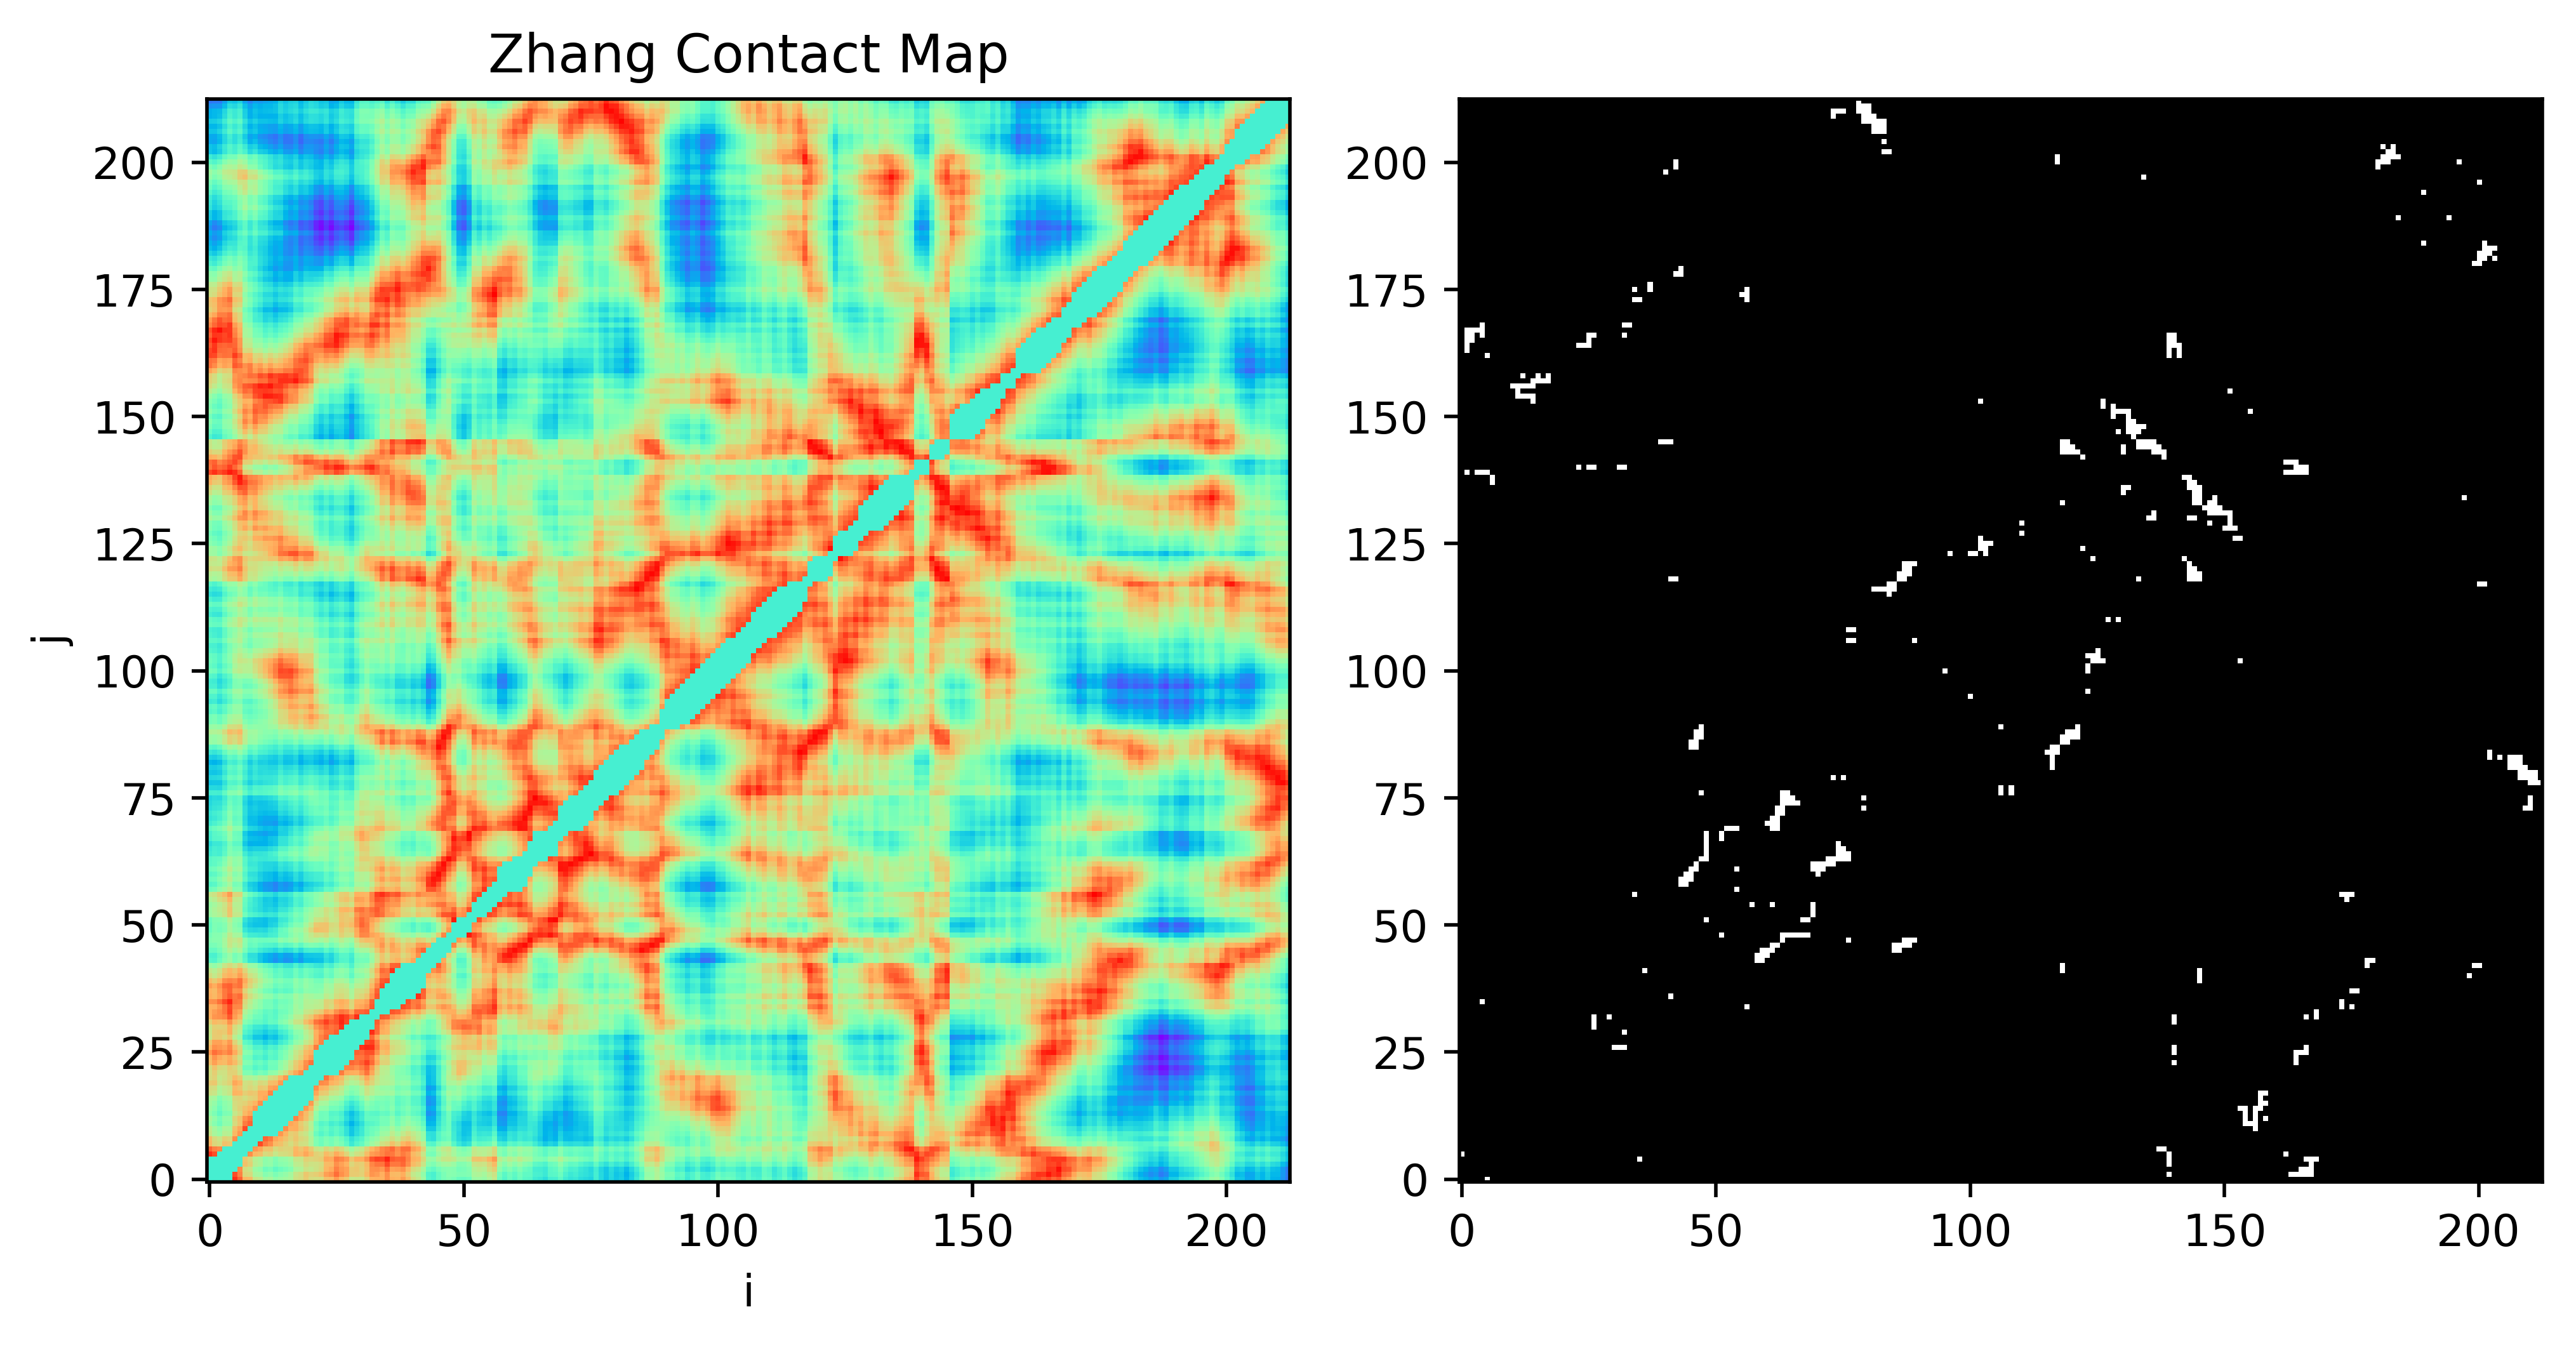

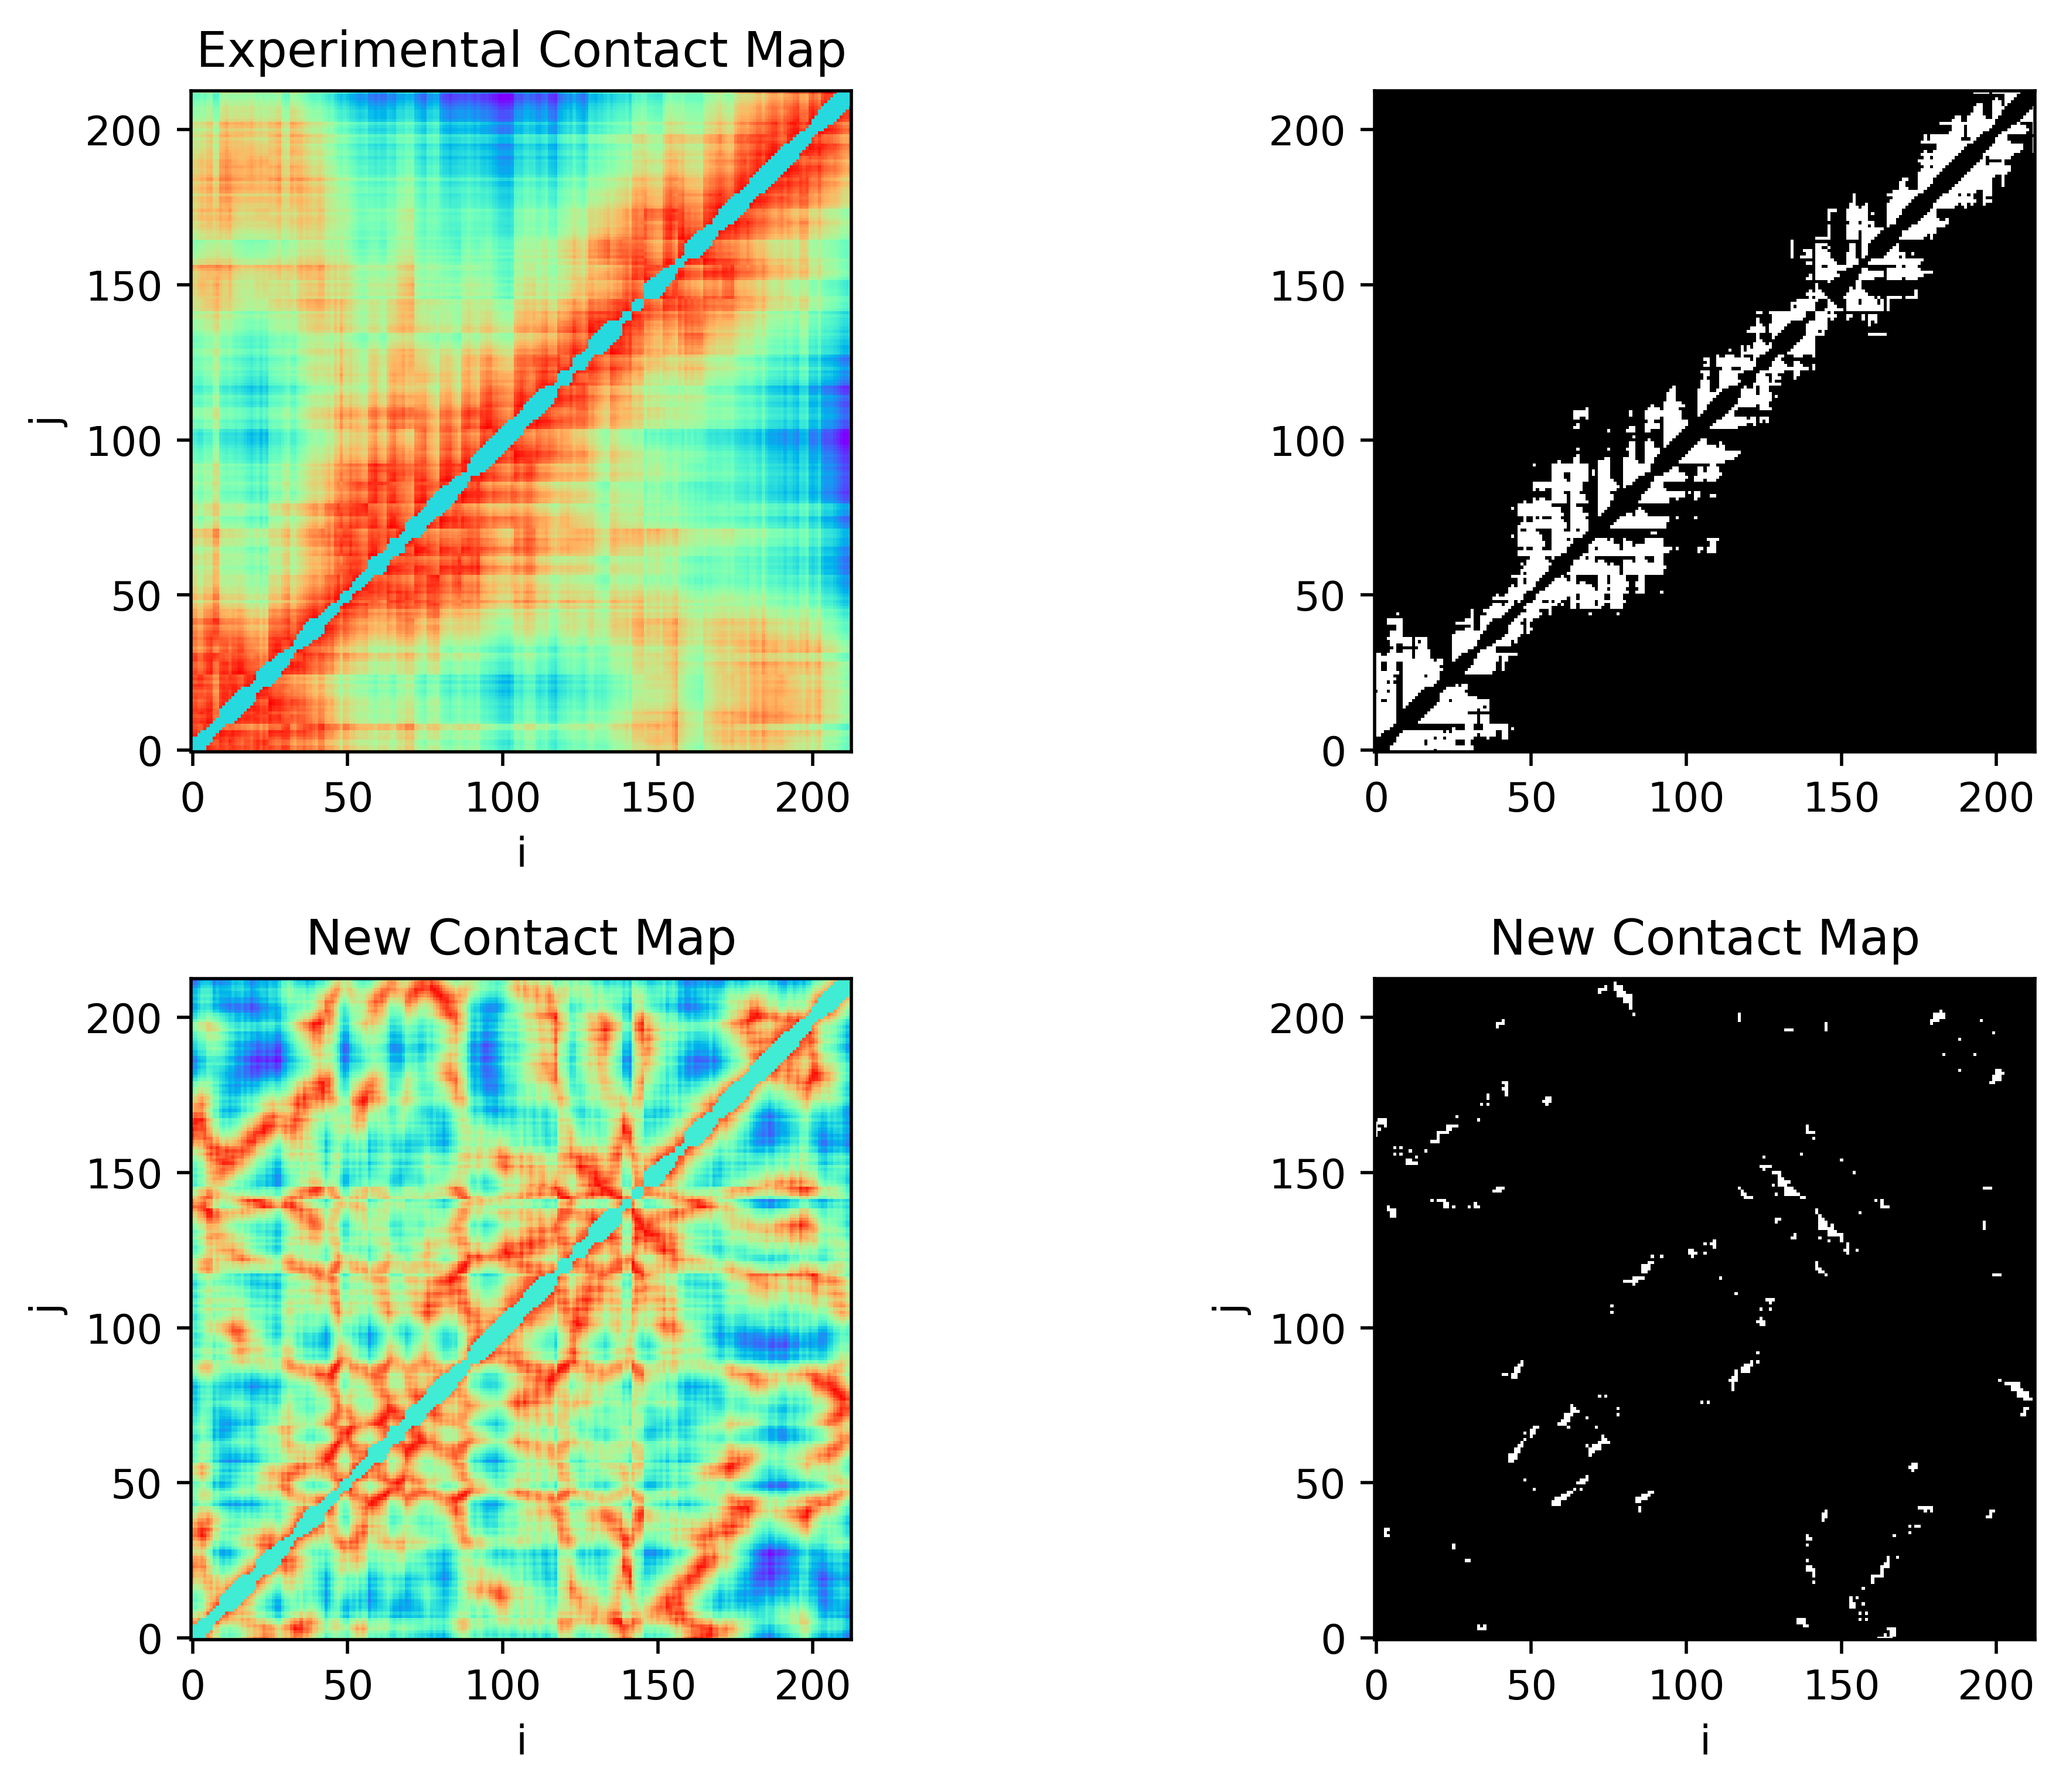

In [4]:
# ----------------------------------------------- #
# GETTING CONTACT MAPS (ZHANG AND EXPERIMENTAL)
# ----------------------------------------------- #
def binary_overlay(distance_matrix, thresh=5.):
    dist_thresh_mask = distance_matrix <= thresh
    return dist_thresh_mask.astype(np.int)


ipdb = 0


# Zhang PDB
try:
        #subject = msa[0]
        #L = len(subject)

        zhang_structure = parser.get_structure(id =pfam_id, file =pfam_id+'.pdb')
        ppb=PPBuilder()
        for pp in ppb.build_peptides(zhang_structure):
                #print(pp.get_sequence())
                #print(pp.get_ca_list())
                L = len(pp.get_ca_list())
        # get coordinates or general information from zhang pdb 
        coords_zhang = []
        coords_zhang = np.zeros((L,3))
        print(coords_zhang.shape)

        
        # extract coords from peptide builder
        for pp in ppb.build_peptides(zhang_structure):
                print(pp.get_sequence())
                for i,ca in enumerate(pp.get_ca_list()):
                        #print(ca.get_coord())
                        #coords_zhang.append(a.get_coord())
                        coords_zhang[i,:] = ca.get_coord()
        zhang_pdb = True
        #sys.exit()
except(FileNotFoundError):
        print('No Zhang or experimental PDB structure')
        zhang_pdb = False

if zhang_pdb:
        # Should have coords 
        #print('original pdb:')
        #print(coords_zhang)
        #print(s_index.shape)

        zhang_coords_remain = np.delete(coords_zhang,cols_removed,axis=0)

        ct_zhang = distance_matrix(zhang_coords_remain,zhang_coords_remain)
        print(ct_zhang)
        ct_zhang_distal = tools.distance_restr(ct_zhang,s_index,make_large=True)
        print('\n\n\n\n')
        
        fig = plt.figure(constrained_layout=True,figsize=(8, 6), dpi=500)
        spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

        #plt.subplot2grid((2,3),(0,0))
        ax_zhang_contact = fig.add_subplot(spec[0,0])

        ax_zhang_contact.set_title('Zhang Contact Map')
        ax_zhang_contact.imshow(ct_zhang_distal,cmap='rainbow_r',origin='lower')
        ax_zhang_contact.set_xlabel('i')
        ax_zhang_contact.set_ylabel('j')
        
        zhang_bin_dist_mat = binary_overlay(ct_zhang_distal, 8.)
        ax_zhang_bin_contact = fig.add_subplot(spec[0,1])
        ax_zhang_bin_contact.imshow(zhang_bin_dist_mat, cmap='gray',origin='lower')
        
        #fig.show()
        #fig.savefig('%s_zhang_contact_map.pdf'%pfam_id, format='pdf', dpi=100)
        #fig.close()

# Experimental PDB
if pfam_id in pdb_ranges.keys():
        chain_str = 'A'
        pdb =   [ [pfam_id , '0', pfam_id       , pdb_ranges[pfam_id][a][1]  ,  pdb_ranges[pfam_id][a][2]  ,pdb_ranges[pfam_id][a][0]  ,chain_str, pdb_ranges[pfam_id][a][1]  ,  pdb_ranges[pfam_id][a][2]] for a in range(0,len(pdb_ranges[pfam_id])) ]
        """for a in range(0,len(pdb_ranges[pfam_id])):
            pdb.append([pfam_id , '0', pfam_id       , pdb_ranges[pfam_id][a][1]  ,\
                   pdb_ranges[pfam_id][a][2]  ,pdb_ranges[pfam_id][a][0]  ,\
                   chain_str, pdb_ranges[pfam_id][a][1]  ,\
                   pdb_ranges[pfam_id][a][2]])
        """
        pdb= np.array(pdb)
        #['PF00186' '69' 'Q5KZ26_GEOKA' '1' '160' '1ZDR' 'B' '1' '160']
        # Create pandas dataframe for protein structure
        df = pd.DataFrame(pdb,columns = ['PF','seq','id','uniprot_start','uniprot_start',\
                                 'pdb_id','chain','pdb_start','pdb_end'])
        print(df.head)
        pdb_id = pdb[ipdb][5]
        pdb_chain = pdb[ipdb][6]
        pdb_start,pdb_end = int(pdb[ipdb][7]),int(pdb[ipdb][8])

        pdb_file = pdb_list.retrieve_pdb_file(str(pdb_id),file_format='pdb')
        #pdb_file = pdb_list.retrieve_pdb_file(pdb_id)
        chain = pdb_parser.get_structure(str(pdb_id),pdb_file)[0][pdb_chain]
        coords_all = np.array([a.get_coord() for a in chain.get_atoms()])
        coords_experimental = coords_all[pdb_start-1:pdb_end]   
    
        print(coords_experimental.shape)

        exp_coords_remain = np.delete(coords_experimental,cols_removed,axis=0)
        print(exp_coords_remain.shape)


        ct_experimental = distance_matrix(exp_coords_remain,exp_coords_remain)
        ct_exp_distal = tools.distance_restr(ct_experimental,s_index,make_large=True)
        print('\n\n\n\n')

        fig_exp = plt.figure(constrained_layout=True,figsize=(8, 6), dpi=500)
        spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig_exp)

        #plt.subplot2grid((2,3),(0,0))
        ax_exp_contact = fig_exp.add_subplot(spec[0,0])

        ax_exp_contact.set_title('Experimental Contact Map')
        ax_exp_contact.imshow(ct_exp_distal,cmap='rainbow_r',origin='lower')
        ax_exp_contact.set_xlabel('i')
        ax_exp_contact.set_ylabel('j')

        exp_bin_dist_mat = binary_overlay(ct_exp_distal, 8)
        ax_exp_bin_contact = fig_exp.add_subplot(spec[0,1])
        ax_exp_bin_contact.imshow(exp_bin_dist_mat, cmap='gray',origin='lower')

        #--------------------------------------------------------------------#
        #New and Improved Contact:
        
        ct = tools.contact_map(pdb,ipdb,cols_removed,s_index)
        ct_distal = tools.distance_restr(ct,s_index,make_large=True)
        
        ax_newContact = fig_exp.add_subplot(spec[1,0])
        ax_newContact.set_title('New Contact Map')
        ax_newContact.imshow(ct_distal,cmap='rainbow_r',origin='lower')
        ax_newContact.set_xlabel('i')
        ax_newContact.set_ylabel('j')
 
        new_exp_bin_dist_mat = binary_overlay(ct_distal, 8)
        ax_newContact = fig_exp.add_subplot(spec[1,1])
        ax_newContact.set_title('New Contact Map')
        ax_newContact.imshow(new_exp_bin_dist_mat,cmap='gray',origin='lower')
        ax_newContact.set_xlabel('i')
        ax_newContact.set_ylabel('j')
        
        #--------------------------------------------------------------------#

        #fig.show()
        #fig.savefig('%s_experimental_contact_map.pdf'%pfam_id, format='pdf', dpi=100)
        #fig.close()

if not zhang_pdb and pfam_id not in pdb_ranges.keys():
        print('no structures to generate ROC')
        sys.exit()
tools.hide_toggle()

## Difference Between Contact Maps
### Difference In Contact Maps
#### PDB from Zhang lab gives distance between CA
#### PDB from experimental structure contact map is generated (Tai's Code works with curated data) with indexing issue because we're dealing with all atomic coordinates (not residue coord)
### Resolution
#### If you use the minimum atomic distance between residues you get a much more accurate picture (PYDCA) (BELOW)
#### OR use the CA distance as with zhang

In [5]:
# ----------------------------------------------- #
# SORTING DI
# ----------------------------------------------- #

try:

        print("         Unpickling DI pickle files for %s"%(pfam_id))
        file_obj = open("%s/DI_ER.pickle"%(pfam_id),"rb")
        DI_er = pickle.load(file_obj)
        file_obj.close()
        file_obj = open("%s/DI_DCA.pickle"%(pfam_id),"rb")
        DI_dca = pickle.load(file_obj)
        file_obj.close()
        file_obj = open("%s/DI_PLM.pickle"%(pfam_id),"rb")
        DI_plm = pickle.load(file_obj)
        file_obj.close()


        if(os.path.exists("%s/DI_ER_sorted.pickle"%(pfam_id))):
                file_obj = open("%s/DI_er_sorted.pickle"%(pfam_id),"rb")
                sorted_DI_er = pickle.load(file_obj)
                file_obj.close()
                file_obj = open("%s/DI_dca_sorted.pickle"%(pfam_id),"rb")
                sorted_DI_dca = pickle.load(file_obj)
                file_obj.close()
                file_obj = open("%s/DI_plm_sorted.pickle"%(pfam_id),"rb")
                sorted_DI_plm = pickle.load(file_obj)
                file_obj.close()


        else:
                print("         Sorting and restraing %d DI pairs for %d positions"%(len(DI_er),len(s_index)))
                # Remove bad distances and Duplicates
                print('         unsorted DI: ',DI_er[0:10])
                DI_er_dup = dp.delete_sorted_DI_duplicates(DI_er)
                sorted_DI_er = tools.distance_restr_sortedDI(DI_er_dup)
                print('         sorted DI: ',sorted_DI_er[0:10])

                # other two methods
                DI_dca_dup = dp.delete_sorted_DI_duplicates(DI_dca)
                sorted_DI_dca = tools.distance_restr_sortedDI(DI_dca_dup)
                DI_plm_dup = dp.delete_sorted_DI_duplicates(DI_plm)
                sorted_DI_plm = tools.distance_restr_sortedDI(DI_plm_dup)

                #print(cols_removed)
                file_obj = open("%s/DI_sorted.pickle"%(pfam_id),"wb")
                pickle.dump(sorted_DI_er,file_obj)
                file_obj.close()

                # other two methods
                file_obj = open("%s/DI_dca_sorted.pickle"%(pfam_id),"wb")
                pickle.dump(sorted_DI_dca,file_obj)
                file_obj.close()
                file_obj = open("%s/DI_plm_sorted.pickle"%(pfam_id),"wb")
                pickle.dump(sorted_DI_plm,file_obj)
                file_obj.close()
except(FileNotFoundError):
        print("         No DI file found ")
        print("         cov_list.npy is incorrect record")
        sys.exit()
tools.hide_toggle()

         Unpickling DI pickle files for QHD43415_15
         Sorting and restraing 45369 DI pairs for 213 positions
         unsorted DI:  [((145, 118), 0.018112983625575625), ((118, 145), 0.018112983625575625), ((196, 201), 0.015277221545899621), ((201, 196), 0.015277221545899621), ((52, 61), 0.0106091602063548), ((61, 52), 0.0106091602063548), ((143, 122), 0.007808106497286953), ((122, 143), 0.007808106497286953), ((143, 145), 0.007753518704119099), ((145, 143), 0.007753518704119099)]
         sorted DI:  [((145, 118), 0.018112983625575625), ((196, 201), 0.015277221545899621), ((52, 61), 0.0106091602063548), ((143, 122), 0.007808106497286953), ((121, 145), 0.007641726928057816), ((143, 121), 0.007111492949283208), ((199, 54), 0.006427634936469135), ((176, 196), 0.005929815223694996), ((109, 47), 0.005921614747648317), ((176, 151), 0.005724157856211642)]


In [6]:
ipdb = 0

if os.path.exists('%s/DP.pickle'%(pfam_id)):
        with open('%s/DP.pickle'%(pfam_id), "rb") as f:\
                pf_dict = pickle.load(f)
        f.close()
else:
        print('no MSA data procesed DP.pickle DNE')
        sys.exit()

ipdb =0
#print(s0[0])
s0 = pf_dict['s0']
s_index = pf_dict['s_index']
s_ipdb = pf_dict['s_ipdb']
cols_removed = pf_dict['cols_removed']


# ATTENTION     # ATTENTION     # ATTENTION
n_var = s0.shape[0] # generated issue when calculating ROC curve ie comparing DI matrix with contact map both of which need to be culled with cols_removed
n_var = len(s_index)

try:

        n_seq = max([coupling[0][0] for coupling in sorted_DI_er])
        di_er = np.zeros((n_var,n_var))
        for coupling in sorted_DI_er:
                #print(coupling[1])
                di_er[coupling[0][0],coupling[0][1]] = coupling[1]
                di_er[coupling[0][1],coupling[0][0]] = coupling[1]

        n_seq = max([coupling[0][0] for coupling in sorted_DI_dca])
        di_dca = np.zeros((n_var,n_var))
        for coupling in sorted_DI_dca:
                #print(coupling[1])
                di_dca[coupling[0][0],coupling[0][1]] = coupling[1]
                di_dca[coupling[0][1],coupling[0][0]] = coupling[1]

        n_seq = max([coupling[0][0] for coupling in sorted_DI_plm])
        di_plm = np.zeros((n_var,n_var))
        for coupling in sorted_DI_plm:
                #print(coupling[1])
                di_plm[coupling[0][0],coupling[0][1]] = coupling[1]
                di_plm[coupling[0][1],coupling[0][0]] = coupling[1]

except(IndexError):
        print('given range %d - %d does not match coupling indices (bad experimental pdb range most likely)'%(pdb_start,pdb_end))
        sys.exit()
tools.hide_toggle()

In [7]:
#----------------- Generate Optimal ROC Curve -----------------------#
msa_outfile = '%s/MSA_%s.fa'%(pfam_id,pfam_id)
ref_outfile = '%s/ref_%s.fa'%(pfam_id,pfam_id)

er_visualizer = contact_visualizer.DCAVisualizer('protein', pdb[ipdb][6], pdb[ipdb][5],
    refseq_file = ref_outfile,
    #sorted_dca_scores = er_plot,
    sorted_dca_scores = sindex_DI_er,
    linear_dist = 5,
    contact_dist = 8.0,
)
dca_visualizer = contact_visualizer.DCAVisualizer('protein', pdb[ipdb][6], pdb[ipdb][5],
    refseq_file = ref_outfile,
    #sorted_dca_scores = mf_plot,
    sorted_dca_scores = sindex_DI_mf,
    linear_dist = 5,
    contact_dist = 8.0,
)
plm_visualizer = contact_visualizer.DCAVisualizer('protein', pdb[ipdb][6], pdb[ipdb][5],
    refseq_file = ref_outfile,
    #sorted_dca_scores = plm_plot,
    sorted_dca_scores = sindex_DI_plm,
    linear_dist = 5,
    contact_dist = 8.0,
)


er_tp_rates_dict = er_visualizer.compute_true_positive_rates()
er_tp_rates = er_tp_rates_dict['dca']
pdb_tp_rates = er_tp_rates_dict['pdb']
er_rank = len(er_tp_rates)
er_ranks = [i + 1 for i in range(er_rank)]

mf_tp_rates_dict = dca_visualizer.compute_true_positive_rates()
dca_tp_rates = mf_tp_rates_dict['dca']
pdb_tp_rates = mf_tp_rates_dict['pdb']
dca_rank = len(dca_tp_rates)
dca_ranks = [i + 1 for i in range(dca_rank)]

plm_tp_rates_dict = plm_visualizer.compute_true_positive_rates()
plm_tp_rates = plm_tp_rates_dict['dca']
pdb_tp_rates = plm_tp_rates_dict['pdb']
plm_rank = len(plm_tp_rates)
plm_ranks = [i + 1 for i in range(plm_rank)]

print(er_tp_rates_dict.keys())

print("Finding Optimal ROC curves for ALL methods")
# find optimal threshold of distance for both DCA and ER
ct_thres = np.linspace(1.5,10.,18,endpoint=True)
n = ct_thres.shape[0]

print('sorted DI ranks ER %d, MF %d, PLM %d, PDB %d'%(er_rank,dca_rank,plm_rank,len(pdb_tp_rates)))


zhang_auc_er = np.zeros(n)
zhang_auc_dca = np.zeros(n)
zhang_auc_plm = np.zeros(n)
for i in range(n):
        p,tp,fp = tools.roc_curve(ct_zhang_distal,di_er,ct_thres[i])
        zhang_auc_er[i] = tp.sum()/tp.shape[0]
        p,tp,fp = tools.roc_curve(ct_zhang_distal,di_dca,ct_thres[i])
        zhang_auc_dca[i] = tp.sum()/tp.shape[0]
        p,tp,fp = tools.roc_curve(ct_zhang_distal,di_plm,ct_thres[i])
        zhang_auc_plm[i] = tp.sum()/tp.shape[0]
        
zhang_i0_er = np.argmax(zhang_auc_er)
zhang_i0_dca = np.argmax(zhang_auc_dca)
zhang_i0_plm = np.argmax(zhang_auc_plm)

zhang_p0_er,zhang_tp0_er,zhang_fp0_er = tools.roc_curve(ct_zhang_distal,di_er,ct_thres[zhang_i0_er])
zhang_p0_dca,zhang_tp0_dca,zhang_fp0_dca = tools.roc_curve(ct_zhang_distal,di_dca,ct_thres[zhang_i0_dca])
zhang_p0_plm,zhang_tp0_plm,zhang_fp0_plm = tools.roc_curve(ct_zhang_distal,di_plm,ct_thres[zhang_i0_plm])


if pfam_id in pdb_ranges.keys():
        exp_auc_er = np.zeros(n)
        exp_auc_dca = np.zeros(n)
        exp_auc_plm = np.zeros(n)
        for i in range(n):
                p,tp,fp = tools.roc_curve(ct_distal,di_er,ct_thres[i])
                exp_auc_er[i] = tp.sum()/tp.shape[0]
                p,tp,fp = tools.roc_curve(ct_distal,di_dca,ct_thres[i])
                exp_auc_dca[i] = tp.sum()/tp.shape[0]
                p,tp,fp = tools.roc_curve(ct_distal,di_plm,ct_thres[i])
                exp_auc_plm[i] = tp.sum()/tp.shape[0]

        exp_i0_er = np.argmax(exp_auc_er)
        exp_i0_dca = np.argmax(exp_auc_dca)
        exp_i0_plm = np.argmax(exp_auc_plm)

        exp_p0_er,exp_tp0_er,exp_fp0_er = tools.roc_curve(ct_distal,di_er,ct_thres[exp_i0_er])
        exp_p0_dca,exp_tp0_dca,exp_fp0_dca = tools.roc_curve(ct_distal,di_dca,ct_thres[exp_i0_dca])
        exp_p0_plm,exp_tp0_plm,exp_fp0_plm = tools.roc_curve(ct_distal,di_plm,ct_thres[exp_i0_plm])
        #--------------------------------------------------------------------#
tools.hide_toggle()


	The reference sequence contains less number of residues compared to PDB chain sequence. 
	Make sure that you have provided correct input data.

	The reference sequence contains less number of residues compared to PDB chain sequence. 
	Make sure that you have provided correct input data.

	The reference sequence contains less number of residues compared to PDB chain sequence. 
	Make sure that you have provided correct input data.


dict_keys(['dca', 'pdb'])
sorted DI ranks ER 22684, MF 21791, PLM 21791, PDB 21791


Plotting
[0.00990099 0.00990099 0.00990099 0.00990099 0.00990099 0.51031903
 0.55460746 0.5267081  0.5591891  0.52566311 0.53477542 0.545094
 0.55119252 0.5456371  0.54453459 0.52428    0.52500841 0.5265615 ]


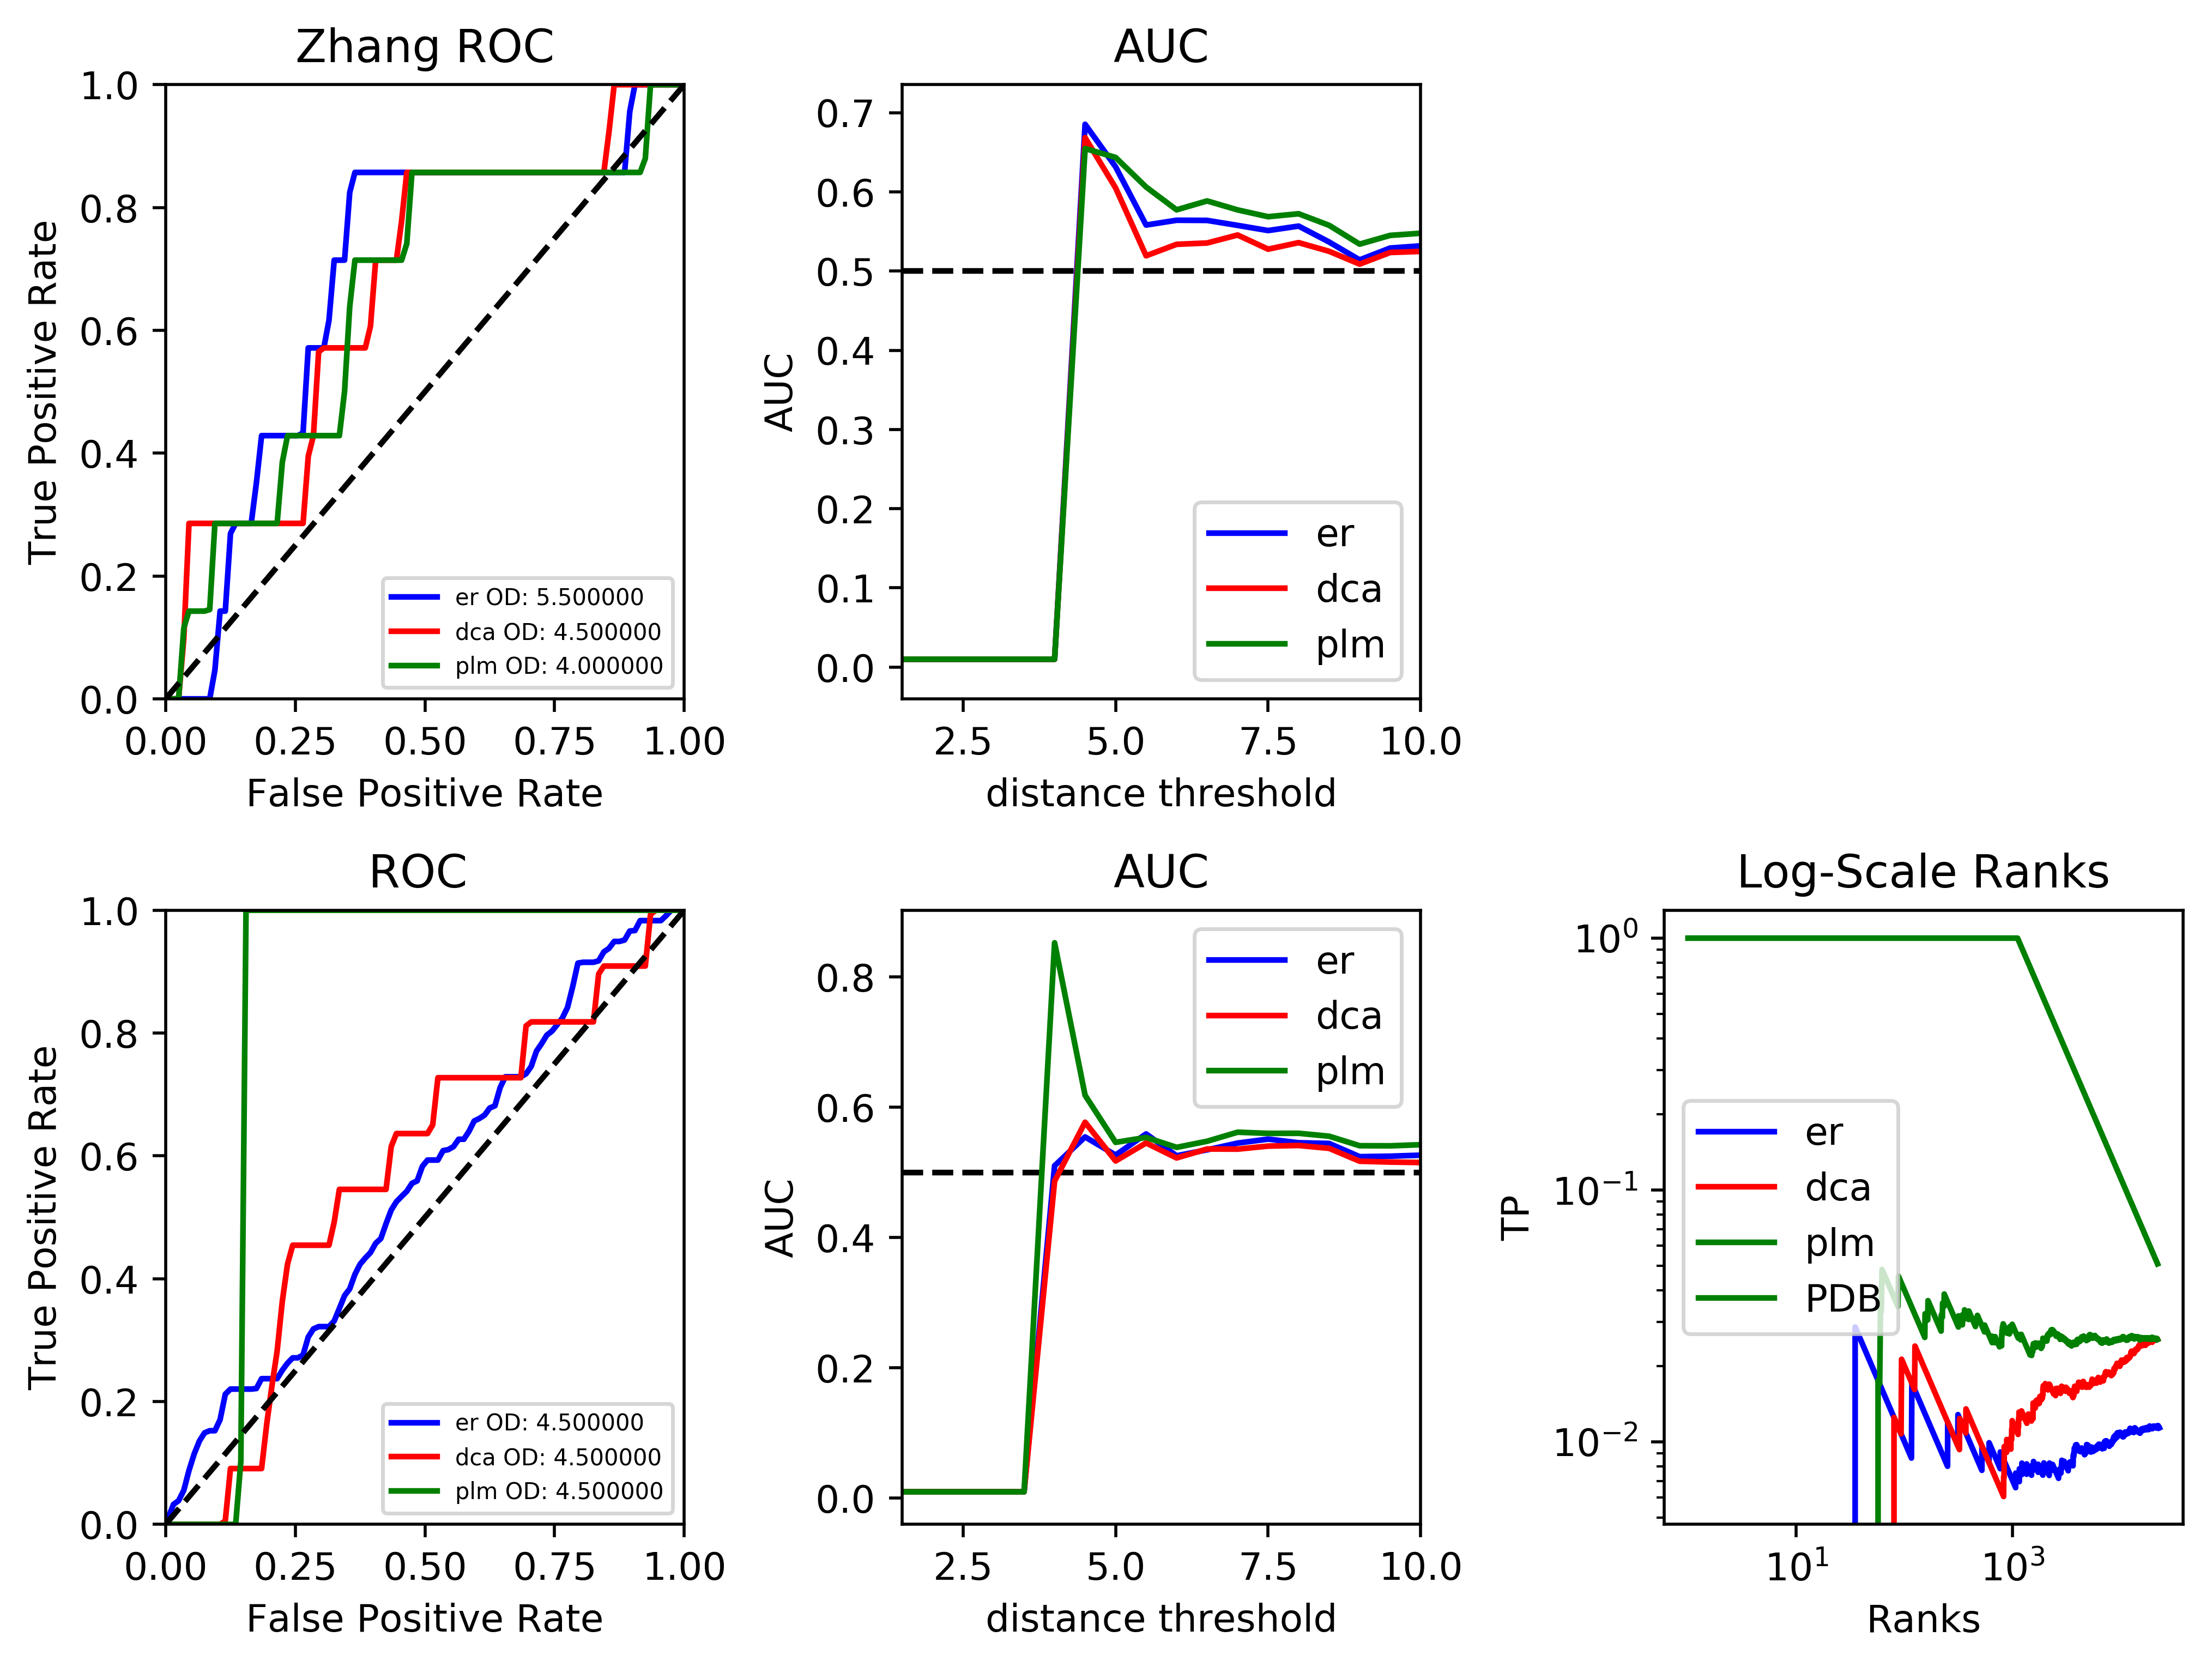

In [11]:
print('Plotting')

fig = plt.figure(constrained_layout=True,figsize=(8, 6), dpi=500)
spec = gridspec.GridSpec(ncols=3, nrows=2, figure=fig)

#plt.subplot2grid((2,3),(0,0))
ax_zhang_roc = fig.add_subplot(spec[0,0])
ax_zhang_roc.set_title('Zhang ROC')
ax_zhang_roc.plot(zhang_fp0_er,zhang_tp0_er,'b-',label="er OD: %f"%(ct_thres[exp_i0_er]))
ax_zhang_roc.plot(zhang_fp0_dca,zhang_tp0_dca,'r-',label="dca OD: %f"%(ct_thres[exp_i0_dca]))
ax_zhang_roc.plot(zhang_fp0_plm,zhang_tp0_plm,'g-',label="plm OD: %f"%(ct_thres[exp_i0_plm]))
ax_zhang_roc.plot([0,1],[0,1],'k--')
ax_zhang_roc.set_xlim([0,1])
ax_zhang_roc.set_ylim([0,1])
ax_zhang_roc.set_xlabel('False Positive Rate')
ax_zhang_roc.set_ylabel('True Positive Rate')
ax_zhang_roc.legend(prop={'size': 6})

# Plot AUC for DCA and ER
#plt.subplot2grid((2,3),(0,1))
ax_zhang_auc = fig.add_subplot(spec[0,1])
ax_zhang_auc.set_title('AUC')
ax_zhang_auc.plot([ct_thres.min(),ct_thres.max()],[0.5,0.5],'k--')
ax_zhang_auc.plot(ct_thres,zhang_auc_er,'b-',label="er")
ax_zhang_auc.plot(ct_thres,zhang_auc_dca,'r-',label="dca")
ax_zhang_auc.plot(ct_thres,zhang_auc_plm,'g-',label="plm")
#print(auc_er)
ax_zhang_auc.set_ylim([zhang_auc_er.min()-0.05,zhang_auc_er.max()+0.05])
ax_zhang_auc.set_xlim([ct_thres.min(),ct_thres.max()])
ax_zhang_auc.set_xlabel('distance threshold')
ax_zhang_auc.set_ylabel('AUC')
ax_zhang_auc.legend()


if pfam_id in pdb_ranges.keys():
        #plt.subplot2grid((2,3),(1,0))
        ax_exp_roc = fig.add_subplot(spec[1,0])
        ax_exp_roc.set_title('ROC ')
        ax_exp_roc.plot(exp_fp0_er,exp_tp0_er,'b-',label="er OD: %f"%(ct_thres[zhang_i0_er]))
        ax_exp_roc.plot(exp_fp0_dca,exp_tp0_dca,'r-',label="dca OD: %f"%(ct_thres[zhang_i0_dca]))
        ax_exp_roc.plot(exp_fp0_plm,exp_tp0_plm,'g-',label="plm OD: %f"%(ct_thres[zhang_i0_plm]))
        ax_exp_roc.plot([0,1],[0,1],'k--')
        ax_exp_roc.set_xlim([0,1])
        ax_exp_roc.set_ylim([0,1])
        ax_exp_roc.set_xlabel('False Positive Rate')
        ax_exp_roc.set_ylabel('True Positive Rate')
        ax_exp_roc.legend(prop={'size': 6})

        # Plot AUC for DCA and ER
        #plt.subplot2grid((2,3),(1,1))
        ax_exp_auc = fig.add_subplot(spec[1,1])
        ax_exp_auc.set_title('AUC')
        ax_exp_auc.plot([ct_thres.min(),ct_thres.max()],[0.5,0.5],'k--')
        ax_exp_auc.plot(ct_thres,exp_auc_er,'b-',label="er")
        ax_exp_auc.plot(ct_thres,exp_auc_dca,'r-',label="dca")
        ax_exp_auc.plot(ct_thres,exp_auc_plm,'g-',label="plm")
        print(exp_auc_er)
        ax_exp_auc.set_ylim([exp_auc_plm.min()-0.05,exp_auc_plm.max()+0.05])
        ax_exp_auc.set_xlim([ct_thres.min(),ct_thres.max()])
        ax_exp_auc.set_xlabel('distance threshold')
        ax_exp_auc.set_ylabel('AUC')
        ax_exp_auc.legend()
        
        # Plot AUC for DCA and ER
        #plt.subplot2grid((2,3),(1,2))
        ax_exp_rank = fig.add_subplot(spec[1,2])
        ax_exp_rank.set_title('Log-Scale Ranks')
        ax_exp_rank.loglog(er_ranks , er_tp_rates,'b-',label="er")
        ax_exp_rank.loglog(dca_ranks,dca_tp_rates,'r-',label="dca")
        ax_exp_rank.plot(plm_ranks,plm_tp_rates,'g-',label="plm")
        ax_exp_rank.loglog(plm_ranks,pdb_tp_rates,'g-',label="PDB")
        ax_exp_rank.set_xlabel('Ranks')
        ax_exp_rank.set_ylabel('TP')
        ax_exp_rank.legend()
        
        fig.savefig('%s_ROC_experimental.pdf'%pfam_id, format='pdf', dpi=1500)
        #fig.show()
        #fig.close()


#--------------------------------------------------------------------#
tools.hide_toggle()

In [9]:
# Using PYDCA contact mapping module
n_var = s0.shape[1]
print("n_var %d"%(n_var))
from scipy.special import comb
print("should have <%d pairs"%(comb(n_var-5,2)))
print("Dimensions of DI Pairs: %d"%(len(sorted_DI_er)))
print("ER: ",len(sorted_DI_er))
print("PLM: ",len(sorted_DI_plm))
print("MF: ",len(sorted_DI_mf))
print("ER Pairs: ", sorted_DI_er[0:10])
tools.hide_toggle()

n_var 213
should have <21528 pairs
Dimensions of DI Pairs: 22791
ER:  22791
PLM:  22578
MF:  22578
ER Pairs:  [((145, 118), 0.018112983625575625), ((196, 201), 0.015277221545899621), ((52, 61), 0.0106091602063548), ((143, 122), 0.007808106497286953), ((121, 145), 0.007641726928057816), ((143, 121), 0.007111492949283208), ((199, 54), 0.006427634936469135), ((176, 196), 0.005929815223694996), ((109, 47), 0.005921614747648317), ((176, 151), 0.005724157856211642)]



	The reference sequence contains less number of residues compared to PDB chain sequence. 
	Make sure that you have provided correct input data.


reference sequence QAWQPVANLMQRMLLEKCDLQGDSATLPKIMMATCQLNTLTLAYNRIFGDKVTARQWTGTLLVSLNDFVADSTLIGCATVHTANKWLIIMDPKTKNVTKENDSKEGFTYICGFIQQKASVAIIHWNADKLMGHFAWWTANVAAIGCKPREQIDYVMNIFTNPIQLSSYLFMSKFPLKLRGAVMSLKEGQINDMILSLSKRIIENNRVVISSDV
213
pdb sequence:  SQAWQPGVAMPNLYKMQRMLLEKCDLQNYGDSATLPKGIMMNVAKYTQLCQYLNTLTLAVPYNMRVIHFGAGSDKGVAPGTAVLRQWLPTGTLLVDSDLNDFVSDADSTLIGDCATVHTANKWDLIISDMYDPKTKNVTKENDSKEGFFTYICGFIQQKLALGGSVAIKITEHSWNADLYKLMGHFAWWTAFVTNVNASSSEAFLIGCNYLGKPREQIDGYVMHANYIFWRNTNPIQLSSYSLFDMSKFPLKLRGTAVMSLKEGQINDMILSLLSKGRLIIRENNRVVISSDVLVNN
297
columns removed [  0   1 256   7  10  11  14  15 273 277 279 282  28  29  38 294 295 296
  42  43 297  45  46  48  49  52  60  61  64  66  68  70  71  73  76  78
  79  80  83  84  88  89  96  98 104 105 113 124 128 129 131 149 160 162
 163 164 169 171 172 174 179 180 192 193 194 197 199 200 201 202 204 205
 209 210 211 212 220 224 225 227 230 231 232 242 245]
85
index [  2   3   4   5   6   8   9  12  13  16  17  18  19  20  21  22  23  24
  

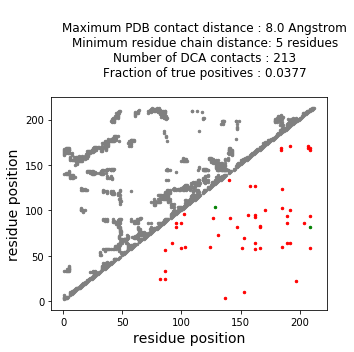


	The reference sequence contains less number of residues compared to PDB chain sequence. 
	Make sure that you have provided correct input data.


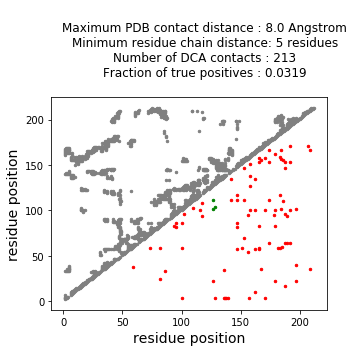


	The reference sequence contains less number of residues compared to PDB chain sequence. 
	Make sure that you have provided correct input data.


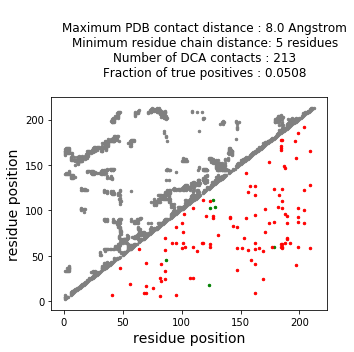


	The reference sequence contains less number of residues compared to PDB chain sequence. 
	Make sure that you have provided correct input data.


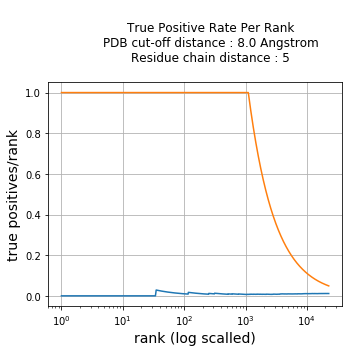


	The reference sequence contains less number of residues compared to PDB chain sequence. 
	Make sure that you have provided correct input data.


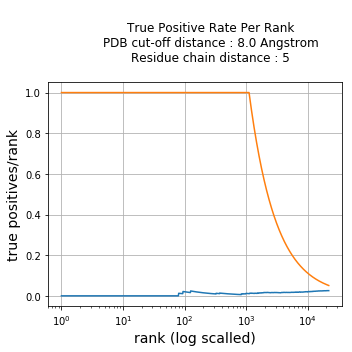


	The reference sequence contains less number of residues compared to PDB chain sequence. 
	Make sure that you have provided correct input data.


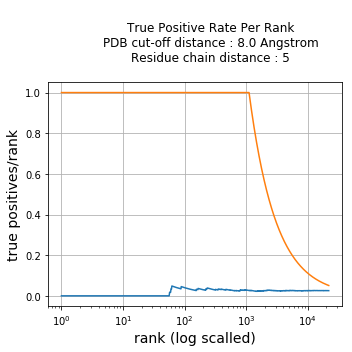

In [10]:
#er_plot = sorted_DI_er[0:50]
#plm_plot = sorted_DI_plm[0:50]
#mf_plot = sorted_DI_mf[0:50]
ref_seq = er_visualizer.get_matching_refseq_to_biomolecule() 
print('reference sequence',ref_seq)
print(len(ref_seq))
biomol_info, pdb_seq = er_visualizer.pdb_content.pdb_chain_sequences[er_visualizer.pdb_chain_id]
print("pdb sequence: ",pdb_seq)
print(len(pdb_seq))

print('columns removed', cols_removed)
print(len(cols_removed))
print('index', s_index)
print(len(s_index))
print('subtracting should give equal amounts: %d'%(len(pdb_seq) - len(ref_seq)))
er_contact_map_data = er_visualizer.plot_contact_map()
mf_contact_map_data = dca_visualizer.plot_contact_map()
plm_contact_map_data = plm_visualizer.plot_contact_map()

er_tp_rate_data = er_visualizer.plot_true_positive_rates()
mf_tp_rate_data = dca_visualizer.plot_true_positive_rates()
plm_tp_rate_data = plm_visualizer.plot_true_positive_rates()


tools.hide_toggle()